<a href="https://colab.research.google.com/github/ccarpenterg/introNLP/blob/master/02b_NLP_and_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-trained Word Embeddings and Neural Networks

In [0]:
!pip install -q tensorflow-datasets==1.3.2

In [23]:
# load Tensorflow 2
%tensorflow_version 2.x

import tensorflow as tf

from tensorflow import keras

import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np

print("Tensorflow version:", tf.__version__)
print("Tensorflow datasets version:", tfds.__version__)

Tensorflow version: 2.1.0
Tensorflow datasets version: 1.3.2


In [0]:
train_validation_split = tfds.Split.TRAIN.subsplit([8, 2])

(train_data, validation_data), test_data = tfds.load(
    'imdb_reviews',
    split = (train_validation_split, tfds.Split.TEST),
    as_supervised=True
)

In [0]:
BUFFER_SIZE = 5000
BATCH_SIZE = 32

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_data))
)

validation_batches = (
    validation_data
    .padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes((validation_data)))
)

test_batches = (
    test_data
    .padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes((test_data)))
)

## Tensorflow Hub embeddings

nnlm-en-dim128-with-normalization: Token based text embedding trained on English Google News 200B corpus.

In [0]:
# Embedding details: https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2
embedding_url = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"

In [21]:
hub_layer = hub.KerasLayer(
    embedding_url,
    input_shape=[],
    dtype=tf.string
)

batch, labels = next(iter(train_batches))
hub_layer_output = hub_layer(batch)

print("Each batch contains {} reviews".format(batch.shape[0]))
print(("The Tensorflow hub layer outputs a " 
       "word embedding vector of length {} " 
       "for each review: {}").format(hub_layer_output.shape[1], hub_layer_output.shape))

Each batch contains 32 reviews
The Tensorflow hub layer outputs a word embedding vector of length 128 for each review: (32, 128)


### Non-trainable Embedding Layer

In [0]:
hub_layer_non_trainable = hub.KerasLayer(
    embedding_url,
    input_shape=[],
    dtype=tf.string,
    trainable=False
)

In [0]:
model_v1 = tf.keras.Sequential([
    hub_layer_non_trainable,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_v1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 124,807,809
Trainable params: 165,121
Non-trainable params: 124,642,688
_________________________________________________________________


### Trainable Embedding Layer

In [0]:
hub_layer_trainable = hub.KerasLayer(
    embedding_url,
    input_shape=[],
    dtype=tf.string,
    trainable=True
)

In [0]:
model_v2 = tf.keras.Sequential([
    hub_layer_trainable,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_v2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 124,807,809
Trainable params: 124,807,809
Non-trainable params: 0
_________________________________________________________________


### Training Our Models on the IMDB Reviews Dataset

In [0]:
EPOCHS = 20
results = dict()

In [0]:
model_v1.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

results['v1'] = model_v1.fit(train_batches,
                             epochs=EPOCHS,
                             validation_data=validation_batches,
                             validation_steps=30)

Epoch 1/20
625/625 [==============================] - 11s 17ms/step - loss: 0.4613 - accuracy: 0.7829 - val_loss: 0.3748 - val_accuracy: 0.8260
Epoch 2/20
625/625 [==============================] - 8s 12ms/step - loss: 0.4151 - accuracy: 0.8107 - val_loss: 0.3608 - val_accuracy: 0.8323
Epoch 3/20
625/625 [==============================] - 8s 13ms/step - loss: 0.4026 - accuracy: 0.8195 - val_loss: 0.3542 - val_accuracy: 0.8344
Epoch 4/20
625/625 [==============================] - 9s 14ms/step - loss: 0.3967 - accuracy: 0.8215 - val_loss: 0.3519 - val_accuracy: 0.8323
Epoch 5/20
625/625 [==============================] - 7s 11ms/step - loss: 0.3889 - accuracy: 0.8274 - val_loss: 0.3503 - val_accuracy: 0.8417
Epoch 6/20
625/625 [==============================] - 8s 12ms/step - loss: 0.3856 - accuracy: 0.8281 - val_loss: 0.3503 - val_accuracy: 0.8302
Epoch 7/20
625/625 [==============================] - 7s 12ms/step - loss: 0.3843 - accuracy: 0.8302 - val_loss: 0.3529 - val_accuracy: 0.834

In [0]:
model_v1.evaluate(test_batches)

    782/Unknown - 9s 12ms/step - loss: 0.3811 - accuracy: 0.8293

[0.3810562680444449, 0.82932]

In [0]:
model_v2.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

results['v2'] = model_v2.fit(train_batches,
                             epochs=EPOCHS,
                             validation_data=validation_batches,
                             validation_steps=30)

Epoch 1/20
625/625 [==============================] - 49s 79ms/step - loss: 0.3311 - accuracy: 0.8548 - val_loss: 0.2263 - val_accuracy: 0.9042
Epoch 2/20
625/625 [==============================] - 49s 78ms/step - loss: 0.1195 - accuracy: 0.9553 - val_loss: 0.2859 - val_accuracy: 0.8948
Epoch 3/20
625/625 [==============================] - 49s 78ms/step - loss: 0.0411 - accuracy: 0.9857 - val_loss: 0.4512 - val_accuracy: 0.8875
Epoch 4/20
625/625 [==============================] - 49s 78ms/step - loss: 0.0256 - accuracy: 0.9908 - val_loss: 0.5935 - val_accuracy: 0.8729
Epoch 5/20
625/625 [==============================] - 49s 78ms/step - loss: 0.0182 - accuracy: 0.9936 - val_loss: 0.6554 - val_accuracy: 0.8687
Epoch 6/20
625/625 [==============================] - 49s 79ms/step - loss: 0.0151 - accuracy: 0.9945 - val_loss: 0.7073 - val_accuracy: 0.8708
Epoch 7/20
625/625 [==============================] - 49s 78ms/step - loss: 0.0111 - accuracy: 0.9958 - val_loss: 0.9605 - val_accuracy:

In [0]:
model_v2.evaluate(test_batches)

    782/Unknown - 9s 11ms/step - loss: 2.3402 - accuracy: 0.8111

[2.340228299009762, 0.81112]

### Plotting Accuracy and Loss

In [0]:
import matplotlib.pyplot as plt

def plot_stats(training_results):

    training_dict = training_results.history

    acc = training_dict['accuracy']
    val_acc = training_dict['val_accuracy']
    loss = training_dict['loss']
    val_loss = training_dict['val_loss']

    epochs = range(1, EPOCHS + 1)

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()

    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

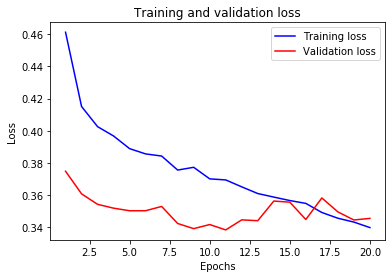

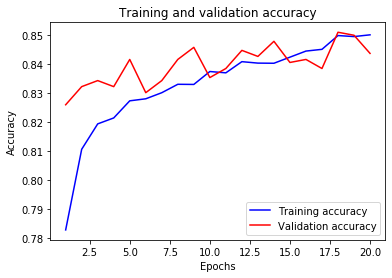

In [0]:
plot_stats(results['v1'])

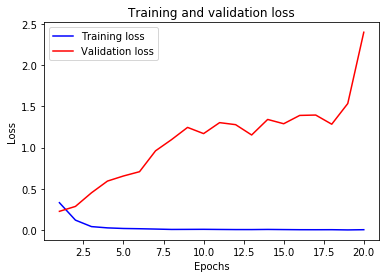

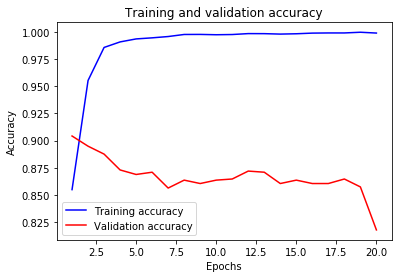

In [0]:
plot_stats(results['v2'])